In [11]:
import pickle
import numpy as np
import pandas as pd
import pygeohash as pgh
import matplotlib.pyplot as plt
import reverse_geocoder as rg
from scipy.stats import entropy
import seaborn as sns
import math


from datetime import datetime
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Detecting Seasonal Patterns in User Movement

There is more to human movement than periodic patterns and social-based movement. While the paper accurately predicts human movement throughout the week, we propose a more all-encompassing analysis that paints a broader picture, exploring monthly and seasonal movement. To do so, we will use the original check-in and friendship datasets from Gowalla and Brightkite and separate them into subsets representing a narrower time of the year. We want to see what mobility patterns are exhibited in different countries and throughout different times of the year: users can go on vacation, travel abroad, and change homes. This would allow us to understand the travelling patterns of users around the world (i.e. who is more likely to travel and where) as well as the distribution of check-ins and their density. We want to produce visualizations showcasing these patterns on a world map. 

Our starting point is the first replication of the Friendship and Mobility paper. We re-use the data-loading and data cleaning part, as well as the technique to determine home locations.

## Loading the data

In [2]:
# The datasets have no headers, so we have to name them for clarity
checkin_header = ['user', 'checkin_time', 'latitude', 'longitude', 'location_id']
edges_header = ['user1', 'user2']

# Load the data by specifying the correct compression algorithm, separator and column names
checkin_brightkite_orig = pd.read_csv('data/loc-brightkite_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_brightkite_orig = pd.read_csv('data/loc-brightkite_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)
checkin_gowalla_orig = pd.read_csv('data/loc-gowalla_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_gowalla_orig = pd.read_csv('data/loc-gowalla_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)

## Cleaning the data

Some of the latitude and longitude values are not in the valid range of [-90, 90] and [-180, 180] respectively. Moreover, the location having (lat, long) = (0,0) is not a valid one. In both datasets, we remove rows in which either of the location attributes are not valid. We also remove the rows of the Brightkite dataset that have NaN values. 

In [4]:
def clean(checkins):
    """ Rids the check-in data of invalid coordinates """
    to_drop = []
    # Select indexes to drop depending on conditions mentionned above 
    to_drop.append(checkins[(checkins['latitude'] < -90.0) | 
                                   (checkins['latitude'] > 90.0)].index)
    to_drop.append(checkins[(checkins['longitude'] < -180.0) | 
                                   (checkins['longitude'] > 180.0)].index)
    to_drop.append(checkins[(checkins['latitude'] == 0) & 
                                   (checkins['longitude'] == 0)].index)
    
    for item in to_drop:
        checkins.drop(item, inplace = True)
    checkins.dropna(inplace = True)
    
    return checkins

In [5]:
# Pass copy of DataFrama in order not to have to reload the original one in case of a mistake
checkin_brightkite = clean(checkin_brightkite_orig.copy())
checkin_gowalla    = clean(checkin_gowalla_orig.copy())

## Adding country information to check-ins

For each check-in, we append the country code corresponding to the country the check-in was made in. This is done using a reverse geohashing library [`reverse_geocoder`](https://github.com/thampiman/reverse-geocoder) that maps coordinates (latitutde, longitude) to information about a specific place (e.g. city, country, country code).

In [21]:
def extract_coordinates(row):
    return (row['latitude'], row['longitude'])

def coordinates_to_country(df):
    """
        Maps the coordinates of a dataframe to the country
        code using reverse geocoding
    """
    coordinates_tuples = list(df.parallel_apply(extract_coordinates, axis = 1))
    geocodes = rg.search(coordinates_tuples)
    return [gc['cc'] for gc in geocodes]

In [7]:
# # Append country codes to each check-in for both datasets
checkin_brightkite['cc'] = coordinates_to_country(checkin_brightkite)
checkin_gowalla['cc']    = coordinates_to_country(checkin_gowalla)

checkin_brightkite.head()

Loading formatted geocoded file...


,user,checkin_time,latitude,longitude,location_id,cc
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,US
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,US
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,US
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,US
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,US


## Determining the location of user homes

Here, the geohash is used to determine the home location for every user. Since this is similar to what was done in the replication, we will not go into detail about the implementation and justification.

In [19]:
def geohash_encode(row, precision = 4):
    """
        Computes and returns the geohash with 
        precision 4 for a given row 
    """
    return pgh.encode(*extract_coordinates(row), precision=precision)

def find_home_cell(checkins, user_id):
    """ Given a user id, finds the most common world cell """
    # Retrieve all the user's check-ins
    group = checkins[checkins['user']  == user_id]
    # Get the most common geohash for the user
    return group.groupby('geohash').size().idxmax()

def find_home(checkins, user_id):
    """
        Given a user id, finds the most common world cell and 
        computes average location to estimate home location
    """
    # Retrieve all the user's check-ins
    group = checkins[checkins['user']  == user_id]
    # Get the most common geohash for the user
    geohash = group.groupby('geohash').size().idxmax()
    
    # Keep all checkins that happened in the most common geohash and compute average position
    return group[group['geohash'] == geohash][['latitude', 'longitude']].mean()

In [9]:
# Compute the geohash for each check-in entry: that will determine the cell in which each check-in belongs
checkin_brightkite['geohash'] = checkin_brightkite.parallel_apply(geohash_encode, axis = 1)
checkin_gowalla['geohash']    = checkin_gowalla.parallel_apply(geohash_encode, axis = 1)

In [11]:
# All the users that made at least 1 check-in
brightkite_users = set(checkin_brightkite.user)
gowalla_users = set(checkin_gowalla.user)

# Create empty DataFrame with user ids and apply function to all users
brightkite_homes = pd.DataFrame(index = brightkite_users).index.to_series().parallel_apply(lambda user_id: find_home(checkin_brightkite, user_id)) 
gowalla_homes = pd.DataFrame(index = gowalla_users).index.to_series().parallel_apply(lambda user_id: find_home(checkin_gowalla, user_id)) 

# Add the country codes to the homes
brightkite_homes['cc'] = coordinates_to_country(brightkite_homes)
gowalla_homes['cc'] = coordinates_to_country(gowalla_homes)

brightkite_homes.head()

,latitude,longitude,cc
0,39.783678,-104.992871,US
1,37.643427,-122.416294,US
2,39.777215,-105.003989,US
3,37.765367,-122.424540,US
4,60.174029,24.937171,FI


In [12]:
# Store homes in dictionary for faster access
brightkite_homes = brightkite_homes.to_dict(orient = 'index')
gowalla_homes = gowalla_homes.to_dict(orient = 'index')

## Adding temporal information to the check-in data

To be able to separate check-ins temporally, we add to each check-in, the month and season it was made in. 

In [151]:
def to_datetime(row):
    """ Returns the string found in the row to the correctly formatted datetime object """
    return datetime.strptime(row['checkin_time'], '%Y-%m-%dT%H:%M:%SZ')

def get_month(row):
    """ Extracts the month from the given row. """
    return to_datetime(row).month

def get_day(row):
    """ Extracts the day from the given row. """
    return to_datetime(row).weekday() # Monday is 0, Sunday is 6

def hour_of_week(row):
    """ Extracts the hour of the week. A week has 168 hours. """
    return to_datetime(row).weekday()*24 + to_datetime(row).hour

def get_season(row):
    """ 
        Returns the season from a certain row
        Adapted from https://stackoverflow.com/a/28688724 
    """
    # Define the datetime intervals according to every season
    Y = 2000 # Leap year to allow input X-02-29, which allows for leap days
    seasons = [('winter', (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
               ('spring', (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
               ('summer', (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
               ('autumn', (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
               ('winter', (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]
    
    date_time = to_datetime(row)
    date_time = date_time.replace(year=Y, hour=0, minute=0, second=0)
    
    return next(season for season, (start, end) in seasons if start <= date_time <= end)

seasons = ['winter', 'spring', 'summer', 'autumn']
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',\
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

In [19]:
# Find the month associated with every check-in
checkin_brightkite['month'] = checkin_brightkite.parallel_apply(get_month, axis=1)
checkin_gowalla['month'] = checkin_gowalla.parallel_apply(get_month, axis=1)

# Find the season associated with every check-in
checkin_brightkite['season'] = checkin_brightkite.parallel_apply(get_season, axis=1)
checkin_gowalla['season'] = checkin_gowalla.parallel_apply(get_season, axis=1)

# Find the day of week associated with every check-in
checkin_brightkite['day_of_week'] = checkin_brightkite.parallel_apply(get_day, axis=1)
checkin_gowalla['day_of_week'] = checkin_gowalla.parallel_apply(get_day, axis=1)

# Find the hour of week assoiated with every check-in (used for entropy) 
checkin_brightkite['hour_of_week'] = checkin_brightkite.parallel_apply(hour_of_week, axis=1)
checkin_gowalla['hour_of_week'] = checkin_gowalla.parallel_apply(hour_of_week, axis=1)

checkin_brightkite.head()

,user,checkin_time,latitude,longitude,location_id,cc,geohash,month,season,day_of_week,hour_of_week
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,US,9xj6,10,autumn,6,145
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,US,9xj6,10,autumn,5,126
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,US,9xj6,10,autumn,5,123
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,US,9xj6,10,autumn,3,90
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,US,9xj6,10,autumn,3,72


## Identify travelers

We now indentify users who travel. We define a traveler as a user who has made at least one check-in outside of his home country (determined by the country of its home location). From this definition, we mark each check-in depending on whether it was made while abroad or not. 

In [8]:
def travel_check(row, homes):
    """ 
        A check-in corresponds to a travel if it was made in a country 
        different than the user's home country
    """
    return row['cc'] != homes[row['user']]['cc']

In [9]:
# Determine whether each check-in corresponds to a check-in made while abroad
checkin_brightkite['is_abroad'] = checkin_brightkite.parallel_apply(lambda row: travel_check(row, brightkite_homes), axis = 1)
checkin_gowalla['is_abroad'] = checkin_gowalla.parallel_apply(lambda row: travel_check(row, gowalla_homes), axis = 1)

**TODO**: add statistics on the data (i.e. where are travelers from)

## When are users more likely to travel ?

During certain periods, it is natural that people break their weakly movenent pattern: whether it is for a vacation or a work trip, users will check-in far from their home. We are interested in understanding these traveling patterns. This entails finding the time of the year users are more likely to check-in at a location abroad (in a country different from their home country) or travel far from home. 

Naturally, users that made check-ins outside of their home country will tend to travel further. For each season, we plot the distribution of home distances for both datasets and separate check-ins made while abroad from the rest. 

In [25]:
# Credits of the function implementation: https://stackoverflow.com/a/15737218
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
        Calculates the great circle distance (in km) between two points 
        on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [26]:
def get_distance_from_home(row, homes):
    """ 
    calulate_home_distance_bk: calulates the distance between two lat/long coordinaes, which
                               in this case are the homes of two friends using the coordinates
                               in the bk_user_homes dataframe
    arg row: a row from the dataframe containingn friend data
    """  
    home_lat = homes[row['user']]['latitude']
    home_long = homes[row['user']]['longitude']

    return haversine(home_lat, home_long, row['latitude'], row['longitude'])

In [24]:
# Compute the distance between each check-in and the home of the user that made it 
checkin_brightkite['distance_from_home'] = checkin_brightkite.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)
checkin_gowalla['distance_from_home'] = checkin_gowalla.parallel_apply(lambda row: get_distance_from_home(row, gowalla_homes), axis=1)

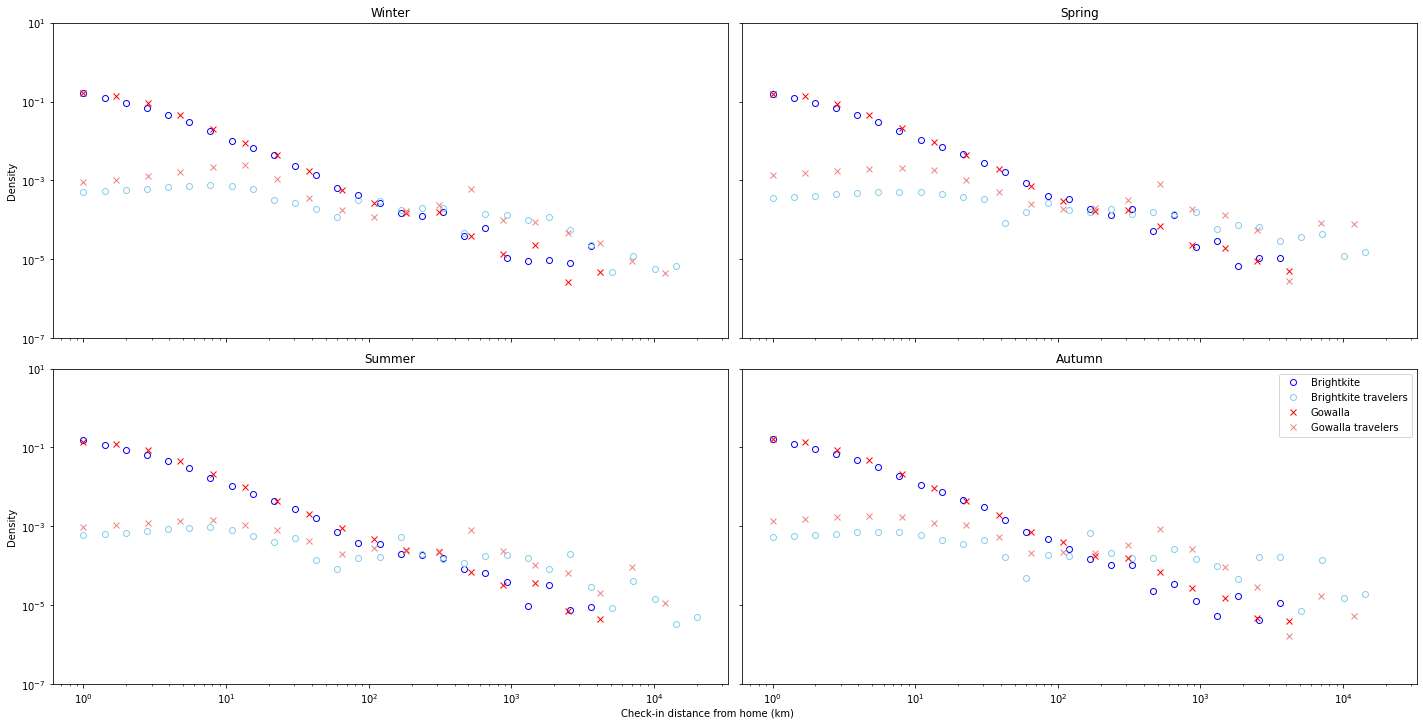

In [66]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10), sharex = True, sharey = True)
axs = axs.ravel()

# Store the max distance, for KDE evaluation logspace
max_dist = math.log10(checkin_brightkite.distance_from_home.max())

for i, season in enumerate(seasons):
    # For each season, plot the distribution of check-in distances from home for check-ins made abroad and in-country 
    checkin_brightkite[(~checkin_brightkite['is_abroad']) & (checkin_brightkite['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'blue', ax = axs[i])
    checkin_brightkite[(checkin_brightkite['is_abroad']) & (checkin_brightkite['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'skyblue', ax = axs[i])
    
    checkin_gowalla[(~checkin_gowalla['is_abroad']) & (checkin_gowalla['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 20), loglog=True, 
                                                                 ls = '', marker = 'x', color = 'red', ax = axs[i])
    checkin_gowalla[(checkin_gowalla['is_abroad']) & (checkin_gowalla['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 20), loglog=True, 
                                                                 ls = '', marker = 'x', color = 'lightcoral', ax = axs[i])
    axs[i].title.set_text(season.capitalize())

# Plot attributes
fig.tight_layout()
plt.ylim(10e-8, 10e0)
plt.legend(['Brightkite', 'Brightkite travelers', 'Gowalla', 'Gowalla travelers'])
fig.text(0.5, 0, 'Check-in distance from home (km)', ha='center')

plt.show()

The trend for each season is very similar. We do not see any particular increase in the probability of traveling further depending on the season. 
- Notice that, for in-country check-ins (solid colors), the probability of checking-in far from home is high at a close distance, and decreases the further the check-in is. 
- For check-ins made abroad (pastel colors), the probability of checking-in close to home is low, but stays rather constant for a long ditance (with a slight decrease towards 1000km).

We plot the frequency of check-ins made abroad for each month, to try and find periods during which people travel more. This will tell us if there are popular months among travelers (i.e summer months). 

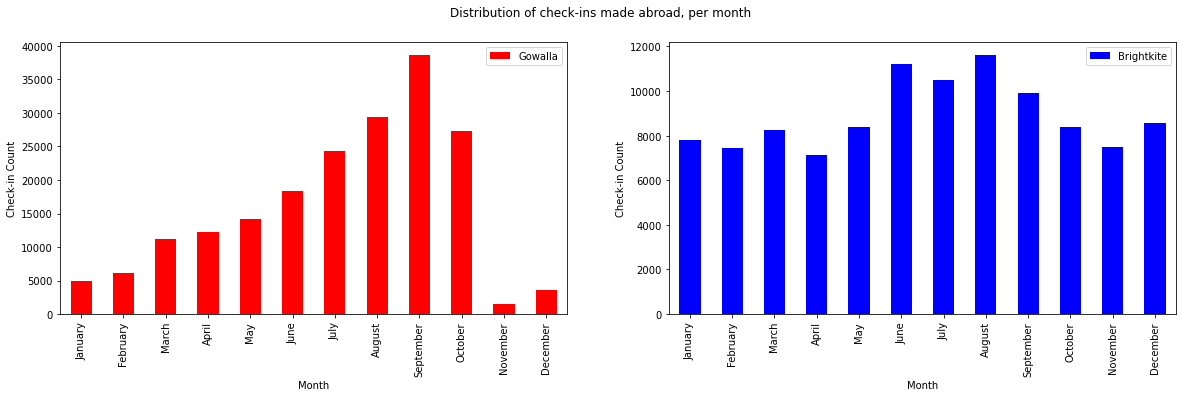

In [151]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
axs = axs.ravel()

# Plot the frequency of check-ins made abroad for each month
checkin_gowalla[checkin_gowalla['is_abroad']].groupby('month')['user'].count().plot.bar(color = 'red', ax = axs[0])
checkin_brightkite[checkin_brightkite['is_abroad']].groupby('month')['user'].count().plot.bar(color = 'blue', ax = axs[1])

for ax in axs:
    ax.set_xlabel('Month')
    ax.set_ylabel('Check-in Count')
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(months.values())
    ax.tick_params('x', rotation = 90)

axs[0].legend(['Gowalla'])
axs[1].legend(['Brightkite'])
plt.suptitle('Distribution of check-ins made abroad, per month')
plt.show()

We see a spike in the frequency of check-ins abroad in June, July, September and August, i.e. summer months. This means that users tend to travel more during summer, even though some smill travel during the rest of the year. 

### Analyzing monthly and seasonal entropy

We will now compute the entropy of check-in locations for each month and season. In order to do so, we need a way to represent neighboring locations as one single entity: we will reuse geohashes, but this time with a larger precision. Even though this does not indicate whether users travel abroad, it still shows the variability of their movement throughout the year. To compute the entropy, we use `scipy.stat`'s entropy method that takes as input value counts. 

In [76]:
# Compute geohash of all check-ins with larger precision
checkin_brightkite['geohash_precision5'] = checkin_brightkite.parallel_apply(lambda row: geohash_encode(row, precision=5), axis = 1)
checkin_gowalla['geohash_precision5'] = checkin_gowalla.parallel_apply(lambda row: geohash_encode(row, precision=5), axis = 1)

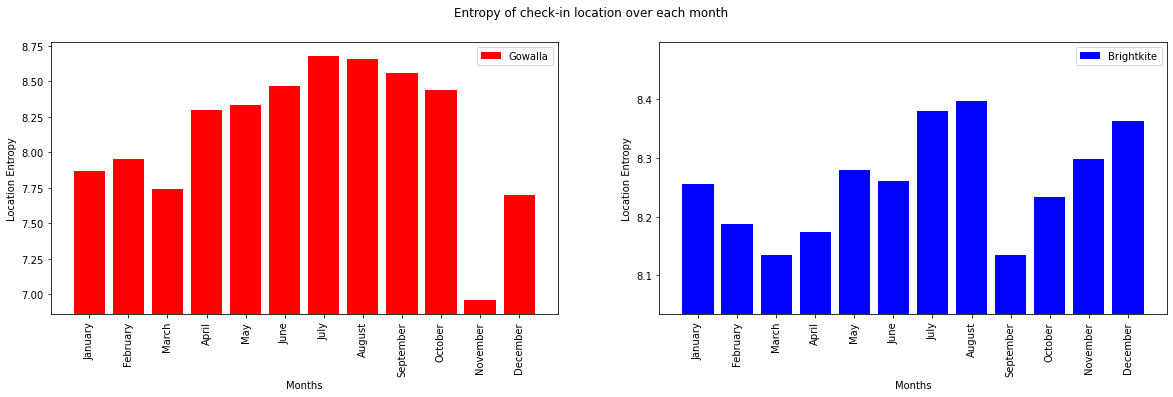

In [116]:
gowalla_monthly_entropies = []
brightkite_monthly_entropies = []

for i in range(12):
    # Compute the entropy of the check-in locations using geohashes over each month
    series = pd.Series(checkin_gowalla[checkin_gowalla['month'] == i+1].geohash_precision5)
    gowalla_monthly_entropies.append(entropy(series.value_counts()))
    
    series = pd.Series(checkin_brightkite[checkin_brightkite['month'] == i+1].geohash_precision5)
    brightkite_monthly_entropies.append(entropy(series.value_counts()))

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
axs = axs.ravel()

# Plot the entropies over each month for both datasets
axs[0].bar(x = list(range(1, 13)), height = gowalla_monthly_entropies, color = 'red')
axs[1].bar(x = list(range(1, 13)), height = brightkite_monthly_entropies, color = 'blue')

# Plot properties 
for ax in axs:
    ax.set_xlabel('Months')
    ax.set_ylabel('Location Entropy')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months.values())
    ax.tick_params(axis='x', rotation= 90)

axs[0].set_ylim(min(gowalla_monthly_entropies) - 0.1, max(gowalla_monthly_entropies) + 0.1)
axs[0].legend(['Gowalla'])
axs[1].set_ylim(min(brightkite_monthly_entropies) - 0.1, max(brightkite_monthly_entropies) + 0.1)
axs[1].legend(['Brightkite'])

plt.suptitle('Entropy of check-in locations over each month')
plt.show()

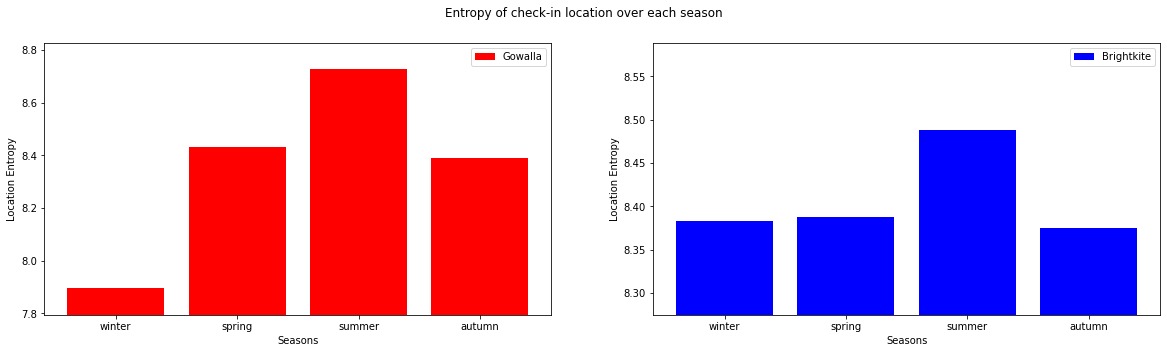

In [118]:
# Repeat the same process as above, but this time over seasons
gowalla_seasonal_entropies = []
brightkite_seasonal_entropies = []

for season in seasons:
    series = pd.Series(checkin_gowalla[checkin_gowalla['season'] == season].geohash_precision5)
    gowalla_seasonal_entropies.append(entropy(series.value_counts()))
    
    series = pd.Series(checkin_brightkite[checkin_brightkite['season'] == season].geohash_precision5)
    brightkite_seasonal_entropies.append(entropy(series.value_counts()))

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
axs = axs.ravel()

# Plot the season location entropies
axs[0].bar(x = seasons, height = gowalla_seasonal_entropies, color = 'red')
axs[1].bar(x = seasons, height = brightkite_seasonal_entropies, color = 'blue')

# Plot properties 
for ax in axs:
    ax.set_xlabel('Seasons')
    ax.set_ylabel('Location Entropy')

axs[0].set_ylim(min(gowalla_seasonal_entropies) - 0.1, max(gowalla_seasonal_entropies) + 0.1)
axs[0].legend(['Gowalla'])
axs[1].set_ylim(min(brightkite_seasonal_entropies) - 0.1, max(brightkite_seasonal_entropies) + 0.1)
axs[1].legend(['Brightkite'])

plt.suptitle('Entropy of check-in locations over each season')
plt.show()

We observe that the entropy is higher during the summer (and the summer months). This shows that the variability of check-ins is higher during that time period and hints at higher non-periodic user movement in summer. That change certainly due to the fact that people tend to go out and take vacations when it's warmer.

### Analyzing weekly entropy on a monthly/seasonal basis

After analyzing the entropy of locations over a whole period of time, we will now analyze the same metric on a weekly basis (for each hour of the week), and plot it for every period of time (i.e. seasons or months).

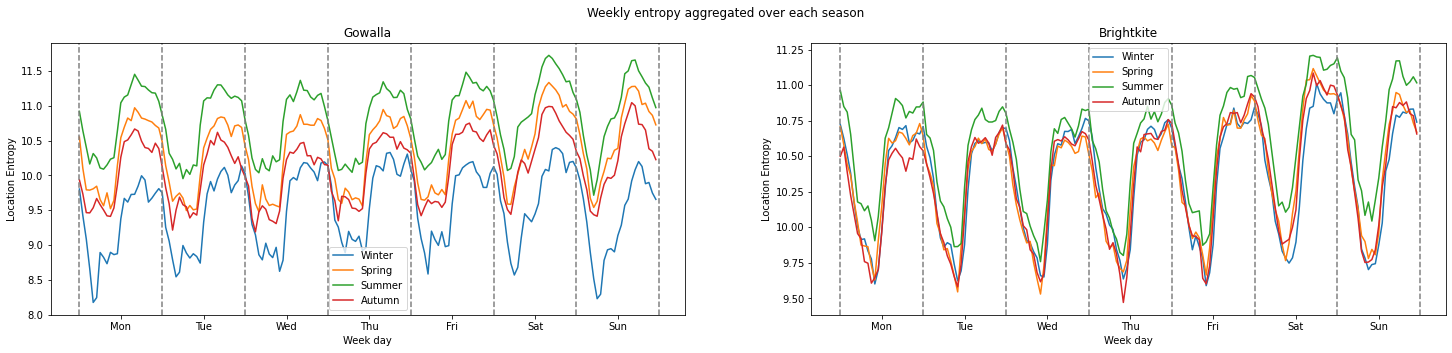

In [141]:
gowalla_seasonal_entropies = []
brightkite_seasonal_entropies = []

for s in seasons: # Repeat the computation for each season
    entropies_gowalla = []
    entropies_brightkite = []
    for i in range(168): 
        # For each hour of the week, compute the entropy of the week's hour for the given season
        entropies_gowalla.append(entropy(checkin_gowalla[(checkin_gowalla['season'] == s) & (checkin_gowalla['hour_of_week'] == i)]\
                                 .geohash_precision5.value_counts(), base = 2))
        entropies_brightkite.append(entropy(checkin_brightkite[(checkin_brightkite['season'] == s) & (checkin_brightkite['hour_of_week'] == i)]\
                                 .geohash_precision5.value_counts(), base = 2))
                                 
    gowalla_seasonal_entropies.append(entropies_gowalla)
    brightkite_seasonal_entropies.append(entropies_brightkite)

fig, axs = plt.subplots(1, 2, figsize = (25, 5), sharex = True)
axs = axs.ravel()

# Plot the entropies for each hour of the week, for each season
for i in range(0,4):
    axs[0].plot(list(range(168)), gowalla_seasonal_entropies[i])
    axs[1].plot(list(range(168)), brightkite_seasonal_entropies[i])       
# Plot vertical lines to show the seperation between days of the week
for i in range(0, 169, 24):
    axs[0].axvline(i, color = 'grey', ls = '--')
    axs[1].axvline(i, color = 'grey', ls = '--')

# Plot properties 
for ax in axs:
    ax.set_xlabel('Week day')
    ax.set_ylabel('Location Entropy')
    ax.set_xticks([24*i + 12 for i in range(7)])
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.legend([s.capitalize() for s in seasons])

axs[0].title.set_text('Gowalla')
axs[1].title.set_text('Brightkite')   
plt.suptitle('Weekly entropy aggregated over each season')
plt.show()

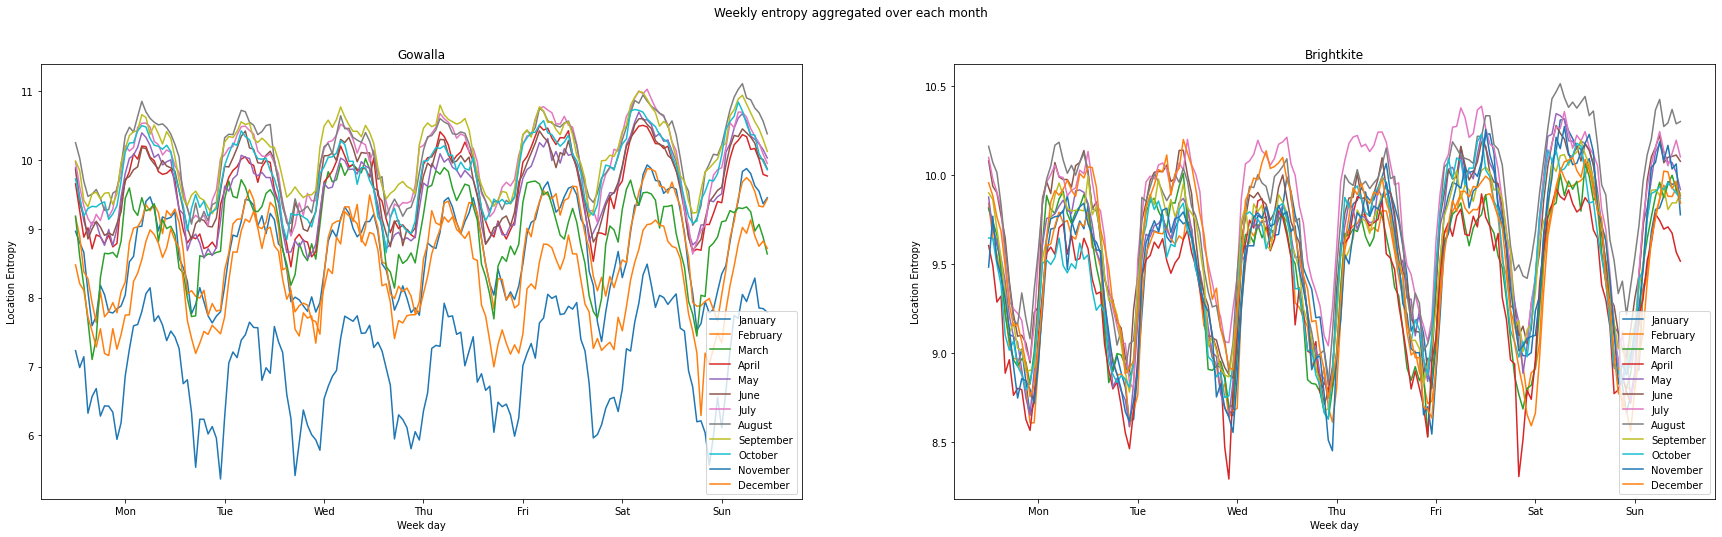

In [147]:
# Repeat the same computation as above, but over the months
gowalla_monthly_entropies = []
brightkite_monthly_entropies = []

for m in range(0, 12):
    entropies_gowalla = []
    entropies_brightkite = []
    for i in range(168):
        entropies_gowalla.append(entropy(checkin_gowalla[(checkin_gowalla['hour_of_week'] == i) & (checkin_gowalla['month'] == m+1)]\
                                 .geohash_precision5.value_counts(), base = 2))
        entropies_brightkite.append(entropy(checkin_brightkite[(checkin_brightkite['hour_of_week'] == i) & (checkin_brightkite['month'] == m+1)]\
                                 .geohash_precision5.value_counts(), base = 2))
    gowalla_monthly_entropies.append(entropies_gowalla)
    brightkite_monthly_entropies.append(entropies_brightkite)    

fig, axs = plt.subplots(1, 2, figsize = (30, 8), sharex = True)
axs = axs.ravel()

for i in range(0,12):
    axs[0].plot(list(range(168)), gowalla_monthly_entropies[i])
    axs[1].plot(list(range(168)), brightkite_monthly_entropies[i])                         

for ax in axs:
    ax.set_xlabel('Week day')
    ax.set_ylabel('Location Entropy')
    ax.set_xticks([24*i + 12 for i in range(7)])
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.legend(months.values())

axs[0].title.set_text('Gowalla')
axs[1].title.set_text('Brightkite')
plt.suptitle('Weekly entropy aggregated over each month')
plt.show()

**TODO** add comment on plots above, and make monthly plot interactive

## Pickle the data

In [ ]:
# pickle.dump(checkin_brightkite, open('pickles/checkin_brightkite', 'wb'))
# pickle.dump(checkin_gowalla, open('pickles/checkin_gowalla', 'wb'))

# pickle.dump(brightkite_homes, open('pickles/brightkite_homes', 'wb'))
# pickle.dump(gowalla_homes, open('pickles/gowalla_homes', 'wb'))

In [4]:
checkin_brightkite = pickle.load(open('pickles/checkin_brightkite', 'rb'))
checkin_gowalla = pickle.load(open('pickles/checkin_gowalla', 'rb'))

In [5]:
brightkite_homes = pickle.load(open('pickles/brightkite_homes', 'rb'))
gowalla_homes = pickle.load(open('pickles/gowalla_homes', 'rb'))

## How does the home location change temporally

During summer, holidays or even weekends, it is common for people to live in another place for a few weeks, e.g in a summer house or mountain cottage. We would now like to study what is the proportion of users that change homes throughout the year, and check if these home changes correspond to a special period of the year. We will carry out this analyzis mainly by computing user homes for each period of the year (months and seasons).

### Brightkite check-ins

To start, we only consider check-ins that were not made abroad, i.e. check-ins that were made in the main home location of the user that made them. We do this to avoid the following scenario. A user from the US is on vacation in Thailand in July, and does some check-ins there: this means we will assign the user a home in Thailand, which is not accurate. 

In [146]:
# Keep check-ins that were not made abroad
brightkite_incountry = checkin_brightkite[~checkin_brightkite['is_abroad']] 

# Print statistics on the numeber of check-ins per user
brightkite_checkins_per_user = {user: len(checkins) for user, checkins in brightkite_incountry.groupby('user')}
pd.Series(brightkite_checkins_per_user).describe()

count    50686.000000
mean        86.500118
std        255.068318
min          1.000000
25%          3.000000
50%         10.000000
75%         48.000000
max       2100.000000
dtype: float64

Notice that 50% of users have made 10 check-ins or less, which is not enough to determine a monthly home location. Moreover, 75% of the users have made 48 check-ins or less. To have pertinent results, we decide to keep the check-ins of users that made 10 check-ins or more: these users are called active users.

In [147]:
# Keep users who made at least 10 check-ins (active users)
brightkite_active_users = [user for user, n_checkins in brightkite_checkins_per_user.items() if n_checkins >= 10 ]

# Keep the check-ins of active users only
brightkite_incountry = brightkite_incountry[brightkite_incountry['user'].isin(active_users)]

Once the check-ins have been filtered, we can proceed to find the home location of users for each period. We store the check-ins and results in dictionary with the months/seasons as keys. 

To compute the home locations, we use the same technique as above, but:
- We consider the set of users that made a check-in during the period of interest, 
- We base the calculation on the check-ins made during the period of interest. 

Note that some users might not have made check-ins during every period of interest: we therefore set the home location of such users for that period as their main (yearly) home location.  

In [ ]:
# Dictionary: month/season -> DataFrame of check-ins made during that month/season
brightkite_monthly = { month: checkins for month, checkins in brightkite_incountry.groupby('month') }
brightkite_season = { season: checkins for season, checkins in brightkite_incountry.groupby('season') }

# Dictionary: month/season -> DataFrame of home locations during that month/season
brightkite_homes_monthly = {}
brightkite_homes_season = {}

for month, checkins in brightkite_monthly.items():
    # Users that made a check-in during the period
    users = checkins.user.unique()
    
    # Find the homes of the users, based on the check-ins made during that month 
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    
    # Add country location
    result['cc'] = coordinates_to_country(result)
    # Compute the distance from users' main home location
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

    # Determine users that didn't made a check-in during that period: retrieve their home location
    missing = pd.DataFrame.from_dict(brightkite_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    # Distance is zero since home location didn't change
    missing['dist_from_yearly_home'] = 0
    
    # Append missing users to result
    result = result.append(missing, ignore_index=True)
    brightkite_homes_monthly[month] = result
    
    print("Done for month", month) # TODO: remove
    
    
# Repeat the process for each season
for season, checkins in brightkite_season.items():
    users = checkins.user.unique()    
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

    missing = pd.DataFrame.from_dict(brightkite_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    missing['dist_from_yearly_home'] = 0
    
    result = result.append(missing, ignore_index=True)
    brightkite_homes_season[season] = result
    
    print("Done for season", season) # TODO: remove

To visualize when does the home location of users change, we decided to (1) plot the average distance from the users' main (yearly) home and to (2) compute the percentage of users that change homes for each period. We say that a user changed homes if the distance from his yearly home is greater than 100km apart. We chose 100km as a threshold because, according to the paper, people live in cities that are separated by that distance or more.

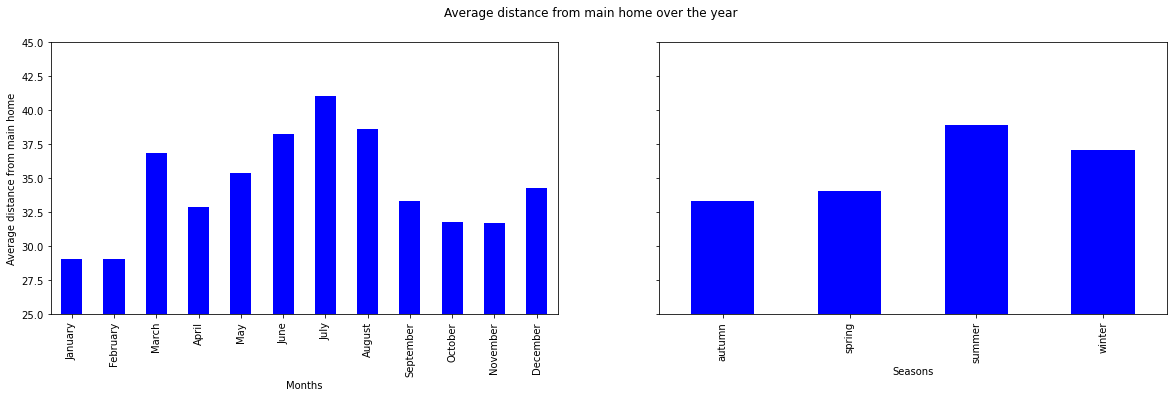

In [219]:
brightkite_monthly_distances = {month: homes.dist_from_yearly_home.mean() for month, homes in brightkite_homes_monthly.items()}
brightkite_season_distances = {season: homes.dist_from_yearly_home.mean() for season, homes in brightkite_homes_season.items()}

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()

pd.Series(brightkite_monthly_distances).plot.bar(ax = axs[0], color = 'blue')
pd.Series(brightkite_season_distances).plot.bar(ax = axs[1], color = 'blue')

axs[0].set_xlabel('Months')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[1].set_xlabel('Seasons')
axs[0].set_ylabel('Average distance from main home')

plt.ylim(25, 45)
plt.suptitle('Average distance from main home over the year')
plt.show()

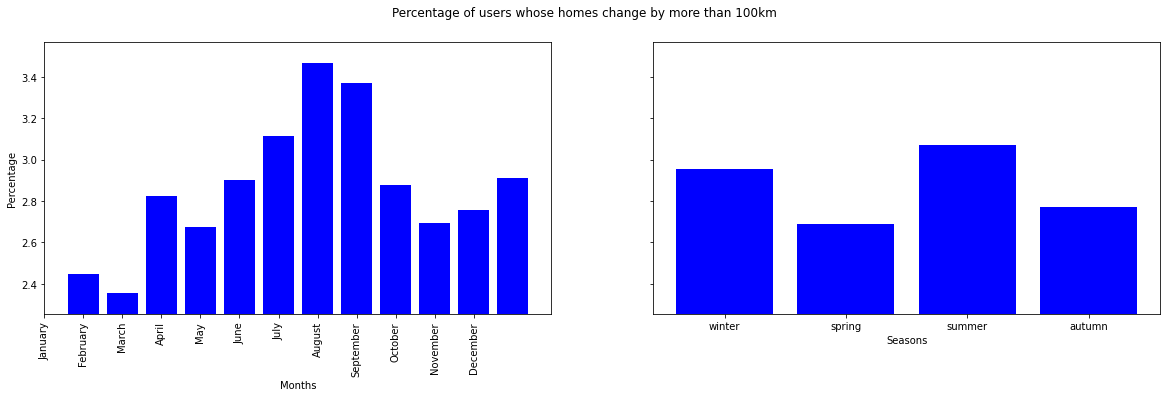

In [222]:
threshold = 100
brightkite_monthly_percentages = []
brightkite_season_percentages = []

for month in range(1, 13):
    distances = brightkite_homes_monthly[month].dist_from_yearly_home
    brightkite_monthly_percentages.append(100*len(distances[distances > threshold])/len(distances))

for season in seasons:
    distances = brightkite_homes_season[season].dist_from_yearly_home
    brightkite_season_percentages.append(100*len(distances[distances > threshold])/len(distances))
        
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()
        
axs[0].bar(x = range(1, 13), height=brightkite_monthly_percentages, color = 'blue')
axs[1].bar(x = seasons, height=brightkite_season_percentages, color = 'blue')

axs[0].set_xlabel('Months')
axs[0].set_ylabel('Percentage')

axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[0].tick_params(axis='x', rotation= 90)
axs[1].set_xlabel('Seasons')
plt.ylim(min(brightkite_monthly_percentages)- 0.1, max(brightkite_monthly_percentages) + 0.1)

plt.suptitle('Percentage of users whose homes change by more than {}km'.format(threshold))
plt.show()

### Gowalla check-ins

We repeat the same process for the Gowalla dataset.

In [223]:
gowalla_incountry = checkin_gowalla[~checkin_gowalla['is_abroad']] 

gowalla_checkins_per_user = {user: len(checkins) for user, checkins in gowalla_incountry.groupby('user')}
pd.Series(gowalla_checkins_per_user).describe()

count    107068.000000
mean         58.381627
std         132.613888
min           1.000000
25%           6.000000
50%          24.000000
75%          54.000000
max        2171.000000
dtype: float64

Notice that 50% of users have made 24 check-ins or less, which is not enough to determine a monthly home location. Moreover, 75% of the users have made 54 check-ins or less. To have pertinent results, we decide to keep the check-ins of users that made 24 check-ins or more: these users are called active users.

In [147]:
# Keep users who made at least 10 check-ins (active users) and their check-ins
gowalla_active_users = [user for user, n_checkins in gowalla_checkins_per_user.items() if n_checkins >= 10 ]
gowalla_incountry = gowalla_incountry[gowalla_incountry['user'].isin(active_users)]

In [224]:
# Dictionary: month/season -> DataFrame of check-ins made during that month/season
gowalla_monthly = { month: checkins for month, checkins in gowalla_incountry.groupby('month') }
gowalla_season = { season: checkins for season, checkins in gowalla_incountry.groupby('season') }

# Dictionary: month/season -> DataFrame of home locations during that month/season
gowalla_homes_monthly = {}
gowalla_homes_season = {}

for month, checkins in gowalla_monthly.items():
    users = checkins.user.unique()    
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, gowalla_homes), axis=1)

    missing = pd.DataFrame.from_dict(gowalla_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    missing['dist_from_yearly_home'] = 0
    
    result = result.append(missing, ignore_index=True)
    gowalla_homes_monthly[month] = result
    
    print("Done for month", month) # TODO: remove
    
    
for season, checkins in gowalla_season.items():
    users = checkins.user.unique()    
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, gowalla_homes), axis=1)

    missing = pd.DataFrame.from_dict(gowalla_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    missing['dist_from_yearly_home'] = 0
    
    result = result.append(missing, ignore_index=True)
    gowalla_homes_season[season] = result
    
    print("Done for season", season) # TODO: remove

Done for month 1
Done for month 2
Done for month 3
Done for month 4
Done for month 5
Done for month 6
Done for month 7
Done for month 8
Done for month 9
Done for month 10
Done for month 11
Done for month 12
Done for season autumn
Done for season spring
Done for season summer
Done for season winter


To visualize when does the home location of users change, we decided to (1) plot the average distance from the users' main (yearly) home and to (2) compute the percentage of users that change homes for each period. We say that a user changed homes if the distance from his yearly home is greater than 100km apart. We chose 100km as a threshold because, according to the paper, people live in cities that are separated by that distance or more.

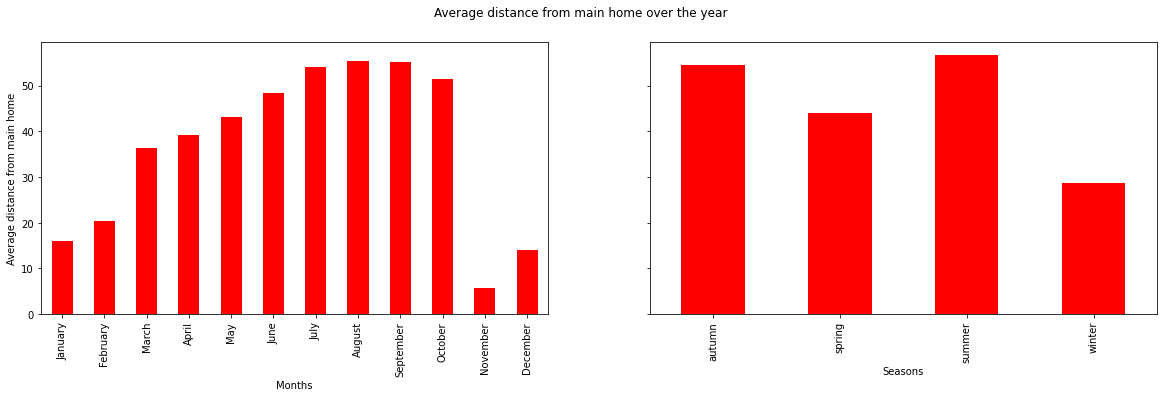

In [226]:
gowalla_monthly_distances = {month: homes.dist_from_yearly_home.mean() for month, homes in gowalla_homes_monthly.items()}
gowalla_season_distances = {season: homes.dist_from_yearly_home.mean() for season, homes in gowalla_homes_season.items()}

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()

pd.Series(gowalla_monthly_distances).plot.bar(ax = axs[0], color = 'red')
pd.Series(gowalla_season_distances).plot.bar(ax = axs[1], color = 'red')

axs[0].set_xlabel('Months')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[1].set_xlabel('Seasons')
axs[0].set_ylabel('Average distance from main home')

# plt.ylim(25, 45)
plt.suptitle('Average distance from main home over the year')
plt.show()

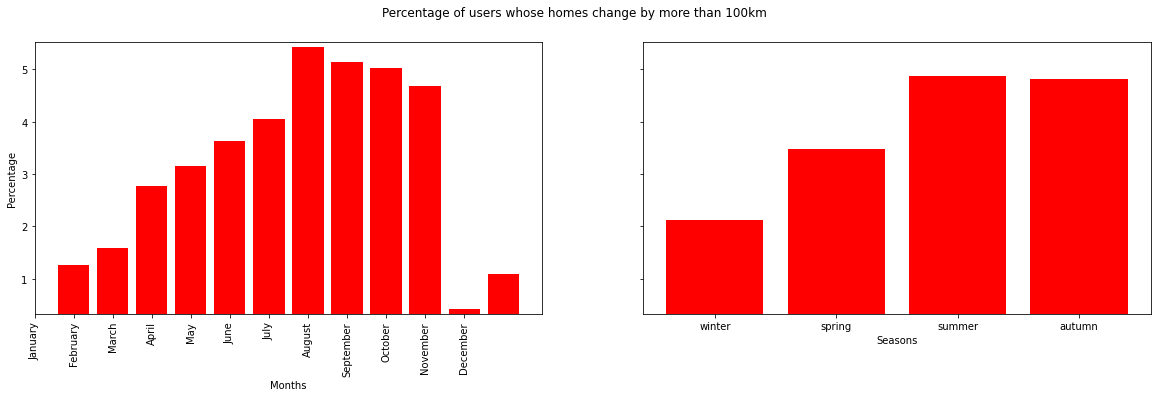

In [228]:
threshold = 100
gowalla_monthly_percentages = []
gowalla_season_percentages = []

for month in range(1, 13):
    distances = gowalla_homes_monthly[month].dist_from_yearly_home
    gowalla_monthly_percentages.append(100*len(distances[distances > threshold])/len(distances))

for season in seasons:
    distances = gowalla_homes_season[season].dist_from_yearly_home
    gowalla_season_percentages.append(100*len(distances[distances > threshold])/len(distances))
        
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()
        
axs[0].bar(x = range(1, 13), height=gowalla_monthly_percentages, color = 'red')
axs[1].bar(x = seasons, height=gowalla_season_percentages, color = 'red')

axs[0].set_xlabel('Months')
axs[0].set_ylabel('Percentage')

axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[0].tick_params(axis='x', rotation= 90)
axs[1].set_xlabel('Seasons')
plt.ylim(min(gowalla_monthly_percentages)- 0.1, max(gowalla_monthly_percentages) + 0.1)

plt.suptitle('Percentage of users whose homes change by more than {}km'.format(threshold))
plt.show()

In [6]:
checkin_brightkite = pickle.load(open('pickles/checkin_brightkite_9_dec', 'rb'))
checkin_gowalla = pickle.load(open('pickles/checkin_gowalla_9_dec', 'rb'))
brightkite_homes = pickle.load(open('pickles/brightkite_homes_9_dec', 'rb'))
gowalla_homes = pickle.load(open('pickles/gowalla_homes_9_dec', 'rb'))

In [142]:
checkin_brightkite['user_nationality'] = checkin_brightkite['user'].parallel_apply(lambda user: brightkite_homes[user]['cc'])
checkin_gowalla['user_nationality'] = checkin_gowalla['user'].parallel_apply(lambda user: gowalla_homes[user]['cc'])

In [169]:
checkin_brightkite_abroad = checkin_brightkite[checkin_brightkite['is_abroad']]
checkin_gowalla_abroad = checkin_gowalla[(checkin_gowalla['is_abroad'])]

brightkite_popular_countries = checkin_brightkite_abroad.groupby('cc').count()['user'].sort_values(ascending=False)
brightkite_popular_countries = list(brightkite_popular_countries[:25].index)
brightkite_popular_countries.remove('US')

gowalla_popular_countries = checkin_gowalla_abroad.groupby('cc').count()['user'].sort_values(ascending=False)
gowalla_popular_countries = list(gowalla_popular_countries[:25].index)
gowalla_popular_countries.remove('US')

brightkite_top_nationalities = checkin_brightkite_abroad.groupby('user_nationality').count()['user'].sort_values(ascending=False)
brightkite_top_nationalities = list(brightkite_top_nationalities[:25].index)
brightkite_top_nationalities.remove('US')

gowalla_top_nationalities = checkin_gowalla_abroad.groupby('user_nationality').count()['user'].sort_values(ascending=False)
gowalla_top_nationalities = list(gowalla_top_nationalities[:25].index)
gowalla_top_nationalities.remove('US')

checkin_brightkite_abroad = checkin_brightkite_abroad[checkin_brightkite_abroad['cc'].isin(brightkite_popular_countries)
                                                     & checkin_brightkite_abroad['user_nationality'].isin(brightkite_top_nationalities)]
checkin_gowalla_abroad = checkin_gowalla_abroad[checkin_gowalla_abroad['cc'].isin(gowalla_popular_countries)
                                                     & checkin_gowalla_abroad['user_nationality'].isin(gowalla_top_nationalities)]




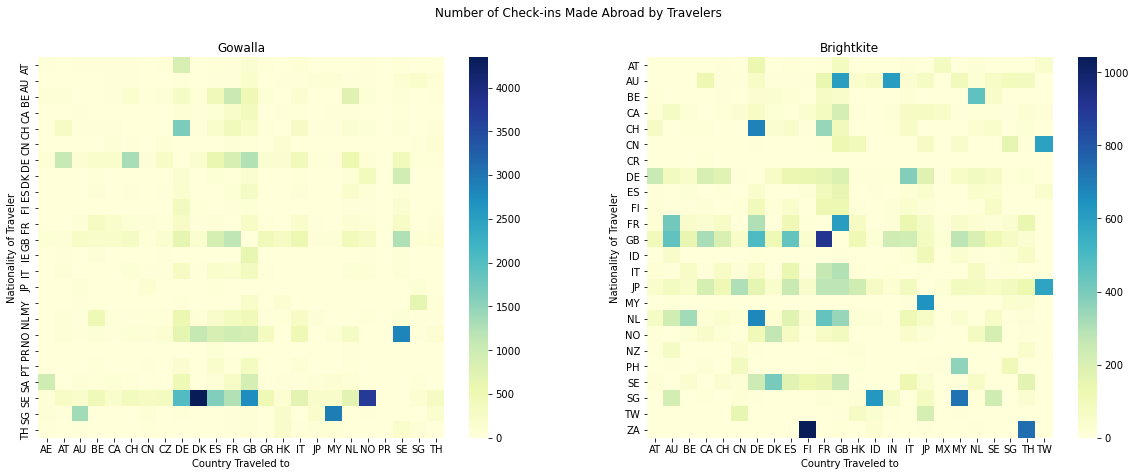

In [170]:
bk_heatmap_data = pd.crosstab(checkin_brightkite_abroad['user_nationality'],checkin_brightkite_abroad['cc'])
gw_heatmap_data = pd.crosstab(checkin_gowalla_abroad['user_nationality'],checkin_gowalla_abroad['cc'])

fig, axs = plt.subplots(1, 2, figsize = (20, 7))
axs = axs.ravel()

sns.heatmap(gw_heatmap_data, cmap="YlGnBu", ax=axs[0])
sns.heatmap(bk_heatmap_data, cmap="YlGnBu", ax=axs[1])


for ax in axs:
    ax.set_xlabel('Country Traveled to')
    ax.set_ylabel('Nationality of Traveler')

axs[0].title.set_text('Gowalla')
axs[1].title.set_text('Brightkite')

plt.suptitle('Number of Check-ins Made Abroad by Travelers')
    
plt.show()

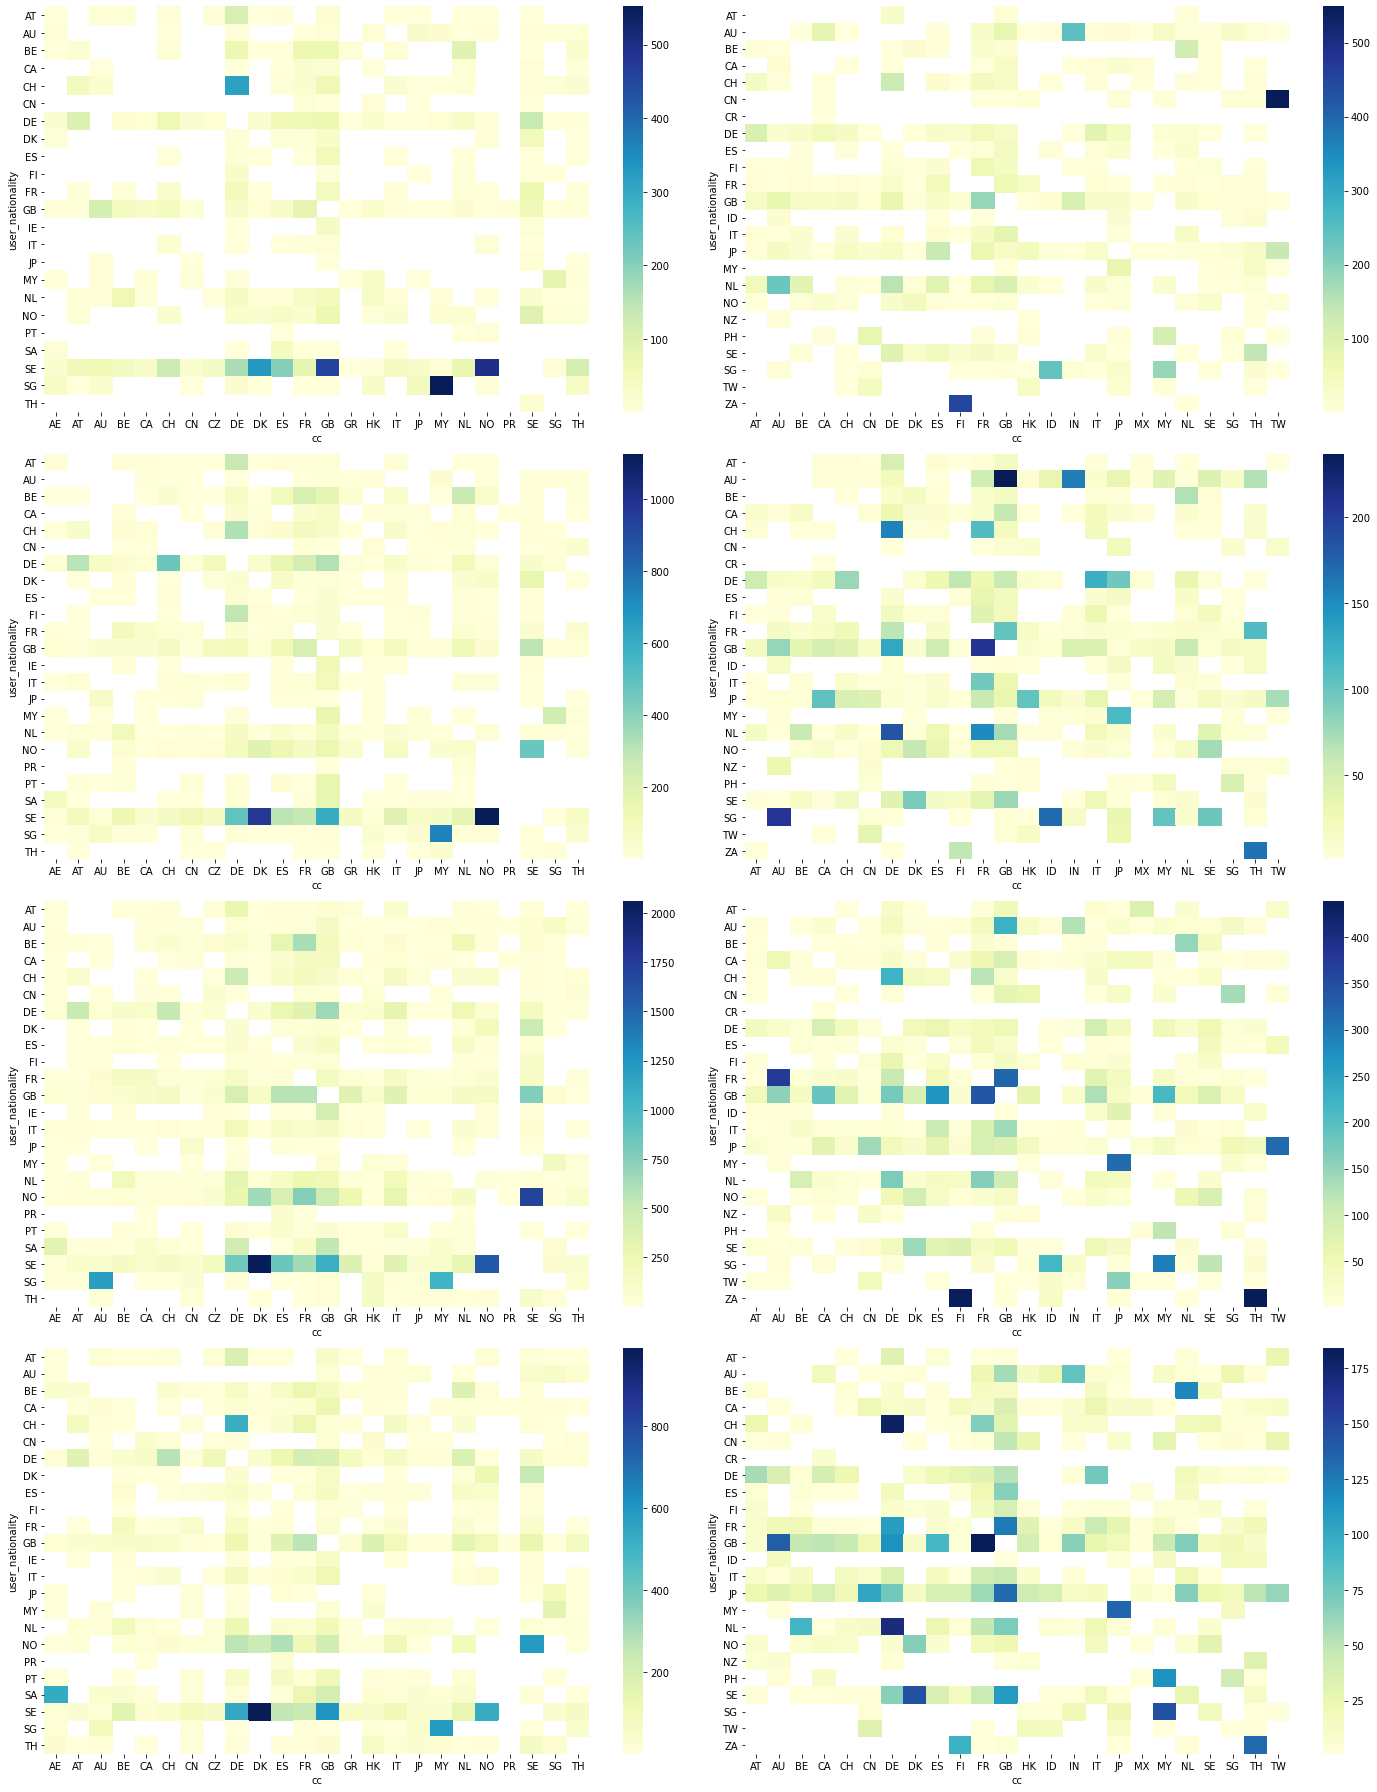

In [176]:
fig, axs = plt.subplots(4, 2, figsize = (20, 25))

for i,season in enumerate(seasons):
    
    bk_seasonal_checkins = checkin_brightkite_abroad[checkin_brightkite_abroad['season'] == season]
    gw_seasonal_checkins = checkin_gowalla_abroad[checkin_gowalla_abroad['season'] == season]
    
    bk_heatmap_season = pd.crosstab(bk_seasonal_checkins['user_nationality'],bk_seasonal_checkins['cc'])
    gw_heatmap_season = pd.crosstab(gw_seasonal_checkins['user_nationality'],gw_seasonal_checkins['cc'])
    
    sns.heatmap(gw_heatmap_season, cmap="YlGnBu", ax=axs[i][0], mask=gw_heatmap_season==0)
    sns.heatmap(bk_heatmap_season, cmap="YlGnBu", ax=axs[i][1], mask=bk_heatmap_season==0)

fig.tight_layout()